In [177]:
import os
import json
import warnings
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from sklearn.gaussian_process.kernels import Matern
from GPy.mappings.constant import Constant
from GPy.kern import Matern52
from GPy.models import GPRegression

from scipy.special import ndtr
from scipy.stats import norm

warnings.filterwarnings('ignore')
# plt.style.use('classic')
plt.style.use('seaborn-paper')
%matplotlib inline

In [178]:
# plotting styles

def nnsvm(rcParams, i=0):
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = 'Ubuntu'
    rcParams['font.monospace'] = 'Ubuntu Mono'
    rcParams['font.size'] = 12 + i
    rcParams['axes.labelsize'] = 12 + i
    rcParams['axes.labelweight'] = 'normal'
    rcParams['xtick.labelsize'] = 10 + i
    rcParams['ytick.labelsize'] = 10 + i
    rcParams['legend.fontsize'] = 12 + i
    rcParams['figure.titlesize'] = 14 + i
    rcParams['lines.linewidth']= 1.8
    rcParams['axes.titlesize'] = 14 + i
alpha_plt = 0.4 # beautification
    
# gifs stuff
gifDir = 'MAB_gifs'
os.makedirs(gifDir, exist_ok=True)
delay = 80

In [179]:
SPINE_COLOR = 'gray'

def format_axes(ax):
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
        
    ax.grid(alpha=.25)

    return ax

In [180]:
def f(x):
    """The function to predict."""
    return 2*((x-3)*np.sin((x-3))) + 2 + 0.5*x

In [181]:
nnsvm(plt.rcParams, -2)

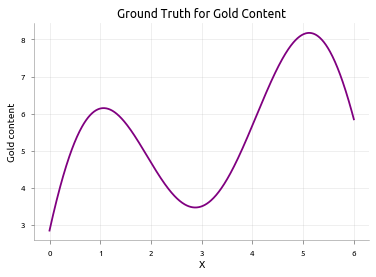

In [182]:
x = np.atleast_2d(np.linspace(0, 6, 600)).T
plt.plot(x, f(x), color='purple', label='GT')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.title("Ground Truth for Gold Content")
format_axes(plt.gca())
# plt.savefig('MAB_gifs/GT.svg', bbox_inches="tight")
# plt.show()

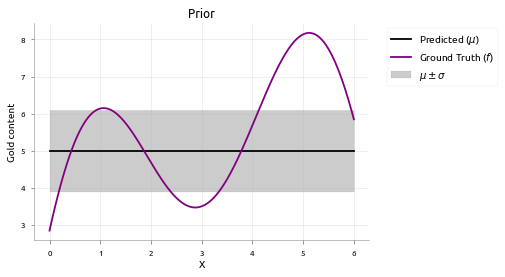

In [183]:
# kernel = Matern(length_scale=1.0)
# kernel = None

y_pred, sigma = 5*np.ones(x.shape).flatten(), 1.1*np.ones(x.shape).flatten()
plt.plot(x, y_pred, 'k', label='Predicted ($\mu$)')
plt.plot(x, f(x), 'purple', label=r'Ground Truth ($f$)')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.title("Prior")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma,
                 color='gray', 
                 alpha=alpha_plt, label=r'$\mu \pm \sigma$')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
format_axes(plt.gca())
# plt.savefig('MAB_gifs/prior.svg', bbox_inches="tight")

In [184]:
def gp_creator(x, y, val = 5):
    y.resize(x.shape[0], 1)
    ker = Matern52(x.shape[1], ARD=True, variance=1)
#     print (x, x.mean())
    mean_fn = Constant(x.shape[1], 1, value=val)
    gp = GPRegression(x, y, kernel=ker, noise_var=0,
                      mean_function = mean_fn)
    gp.optimize()
    return gp

In [185]:
val = 5

In [186]:
class ACQ:
    def acq_fn(self, *args, **kwargs):
        raise NotImplemented
    def __str__(self):
        return self.__class__.__name__
    def __call__(self, *args, **kwargs):
        return self.acq_fn(*args, **kwargs)

class ACQ1(ACQ):
    def acq_fn(self, gp, x, lam = 0.4, **kwrags):
        """
        gp: sklearn.GPRegresssor
        lam: float, where the objective is: \mu(x) + \lambda \sigma(x)
        """
        y_pred, sigma = [t.flatten() for t in gp.predict(x)]
        return y_pred + lam*sigma

In [187]:
def rargmax(b):
    """Randomly tie breaking argmax"""
    return np.random.choice(np.flatnonzero(b == b.max()))

In [188]:
# Code is heavily borrowed from: https://modal-python.readthedocs.io/
# en/latest/_modules/modAL/acquisition.html#max_PI
class PI(ACQ):
    def acq_fn(
        self, gp, x, mu=5., eps=0.01, **kwargs):
        """
        gp: sklearn.GPRegresssor
        """
        y_pred, sigma = [t.flatten() for t in gp.predict(x)]
        cdf = ndtr((y_pred - mu - eps)/sigma)
        return cdf

In [189]:
import scipy.stats as stats
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [48]:
from matplotlib.markers import MarkerStyle


In [217]:
def pi_cdf_plot(gp, x, train_X, train_y, x_locs, val, eps=0.01):
    '''gp: trained gp
    x: all x pos
    train_X: locations sensed till now
    train_y: sensed functional values
    x_locs: points on x axis we would like to visualize pi values
    '''
    data = []
    locs = [np.argmin(abs(x - temp)) for temp in x_locs]

    for kk, x_loc in enumerate(x_locs):

        # setup
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 9),
                               sharex=True)
        p = PI()
        gp = gp_creator(train_X, train_y, val)
        mu_plus = max(train_y) + eps
        acq_pi = p(gp, x, mu=mu_plus, eps=eps)
        
        mu, sig = [t.flatten() for t in gp.predict(x)]
        plt.plot(
            x, mu, zorder=10,
            color='black', 
            label=r'Predictive Mean ($\mu$)',
        )
        plt.fill_between(x.flatten(), 
                           mu + sig, mu - sig, 
                           color='grey', 
                           alpha=.2,
                           label=r'$\mu \pm \sigma$')
        # plotting mu_plus
        ax[1].plot(x, len(x)*[mu_plus], '-.b',
                 label=r'Max Detected $(f(x^+))$')

        gran = 500
        y_linspace = np.linspace(0, 10, gran)

        # finding where y_linspace meets mu_plus
        mu_plus_ix = np.argmin(abs(y_linspace - mu_plus))
        loc = locs[kk]
        

        # Plotting training points
        ax[1].scatter(
            x_locs, mu[locs], 
            facecolor='none',
            linewidth=1.6,
            linestyle='dotted',
            color='k',
            zorder=10,
            s=80,
            label='Candidate points' 
        )
        ax[1].scatter(
            train_X, train_y, 
            color='k',
            zorder=10,
            s=80,
            label='Training points' 
        )

        
        x_linspace = stats.norm.pdf(
            y_linspace, 
            mu[loc], 
            sig[loc]
        ) + x[loc]
        ax[1].set_xlim(x.min(), x.max())
        ax[1].set_ylim(min(mu - sig), max(mu + sig))
#         x_linspace = np.clip(x_linspace, x.min(), x.max())
#         mask1 = np.where(x_linspace > x.min())
#         mask2 = np.where(x_linspace < x.max())
#         fmask = np.intersect1d(mask1, mask2)
#         x_linspace = x_linspace[fmask]
#         y_linspace = y_linspace.flatten()[fmask]
        
#         out1 = []
#         out2 = []
#         for a, b in zip(x_linspace, y_linspace):
#             if a >= min(x) and a <= max(x):
#                 out1.append(a)
#                 out2.append(b)

        ax[1].plot(
            x_linspace, y_linspace, 
            color='g', zorder=12,
#             label=f'Gaussian PDF at X = {x_loc:.2f}',
        )
        
#         out1 = []
#         out2 = []
#         for a, b in zip(x_linspace[mu_plus_ix :], 
#                         y_linspace[mu_plus_ix :]):
#             if a > min(x) and a < max(x):
#                 out1.append(a)
#                 out2.append(b)
                
        mu_line_part = np.array([mu_plus] * len(x_linspace[mu_plus_ix:]))
        ax[1].fill_between(
            x_linspace[mu_plus_ix:], 
            y_linspace[mu_plus_ix:],
            mu_line_part.flatten(), 
            color='g', zorder=13,
            alpha=.6, label="Probability of Improvement",
        )
        
        mu_line_part = np.array([mu_plus] * len(x_linspace[:mu_plus_ix]))
        ax[1].fill_between(
            x_linspace[:mu_plus_ix], 
            y_linspace[:mu_plus_ix],
            mu_line_part.flatten(), 
            color='g', 
            alpha=.1,
        )
        
        ax[0].set_ylim(-.03, .8)
        ax[0].plot(x, acq_pi)
        print (x.flatten()[loc])
        print (acq_pi[loc])
        ax[0].scatter(x.flatten()[loc], acq_pi[loc], s = 100,
                      marker = MarkerStyle('X'), color='g',
                      label=r"$\alpha_{PI}$" + f" at X = {x_loc:.2f}",)
        ax[0].set_ylabel(r"Acquisition Function ($\alpha_{PI}$)")
#         ax[0].set_title(r"Acquisition Function ($\alpha_{PI}$) vs X")
        ax[0].legend()

        ax[1].set_xlabel("X")
        ax[1].set_ylabel("Gold Content")
#         ax[1].set_title(f"CDF (Shaded regions) for X = {x_loc:.2f}")
        ax[1].legend()

        format_axes(ax[0])
        format_axes(ax[1])
        dirName = 'MAB_pngs/pi_cdf_new'
        os.makedirs(dirName, exist_ok=True)
        plt.savefig(f"{dirName}/{kk}.png", bbox_inches="tight", dpi=180)
        plt.show()
        plt.close()
    return

In [218]:
nnsvm(plt.rcParams, -1)

train_X = np.array([[.3],[2.2], [3.7]])
train_y = f(train_X)

0.0
0.03084136034874597


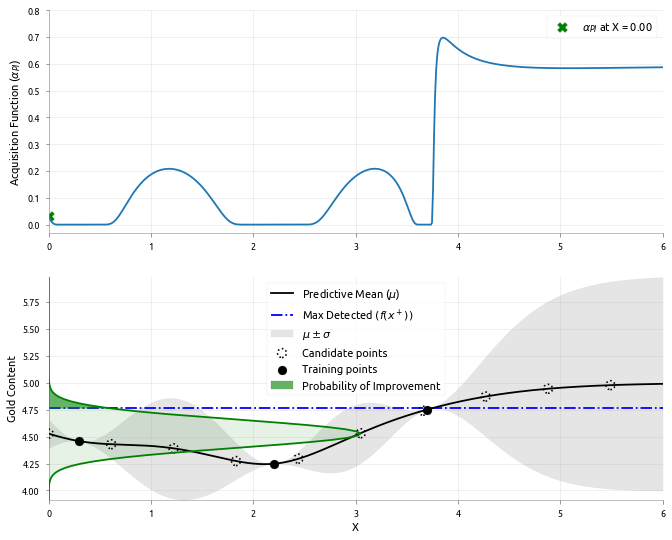

0.6110183639398998
0.004496693185131727


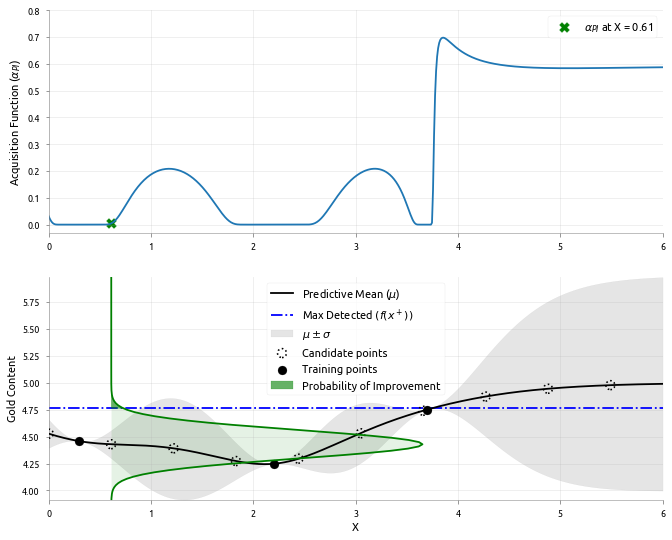

1.2220367278797997
0.20710198835234356


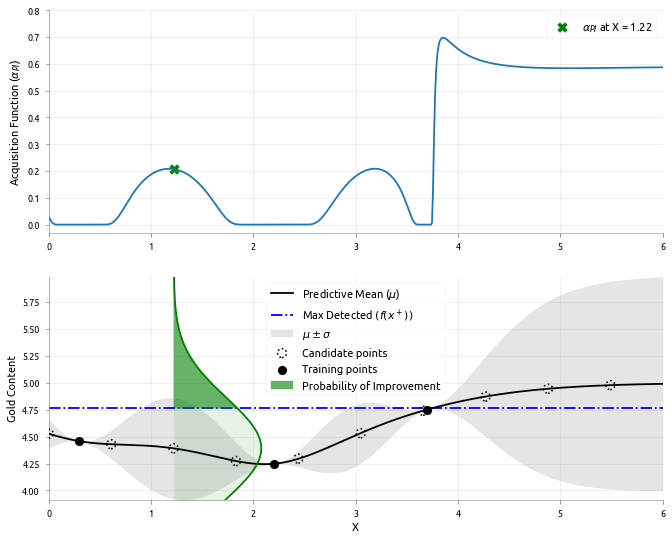

1.8330550918196995
0.001325931585208732


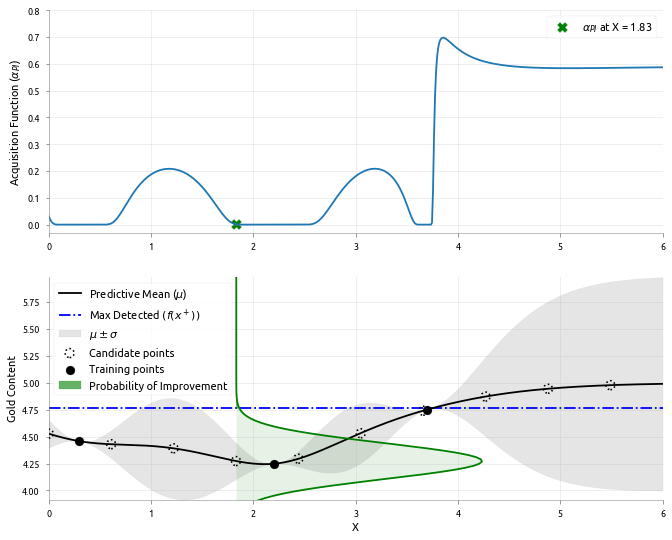

2.4440734557595993
9.225850000958678e-11


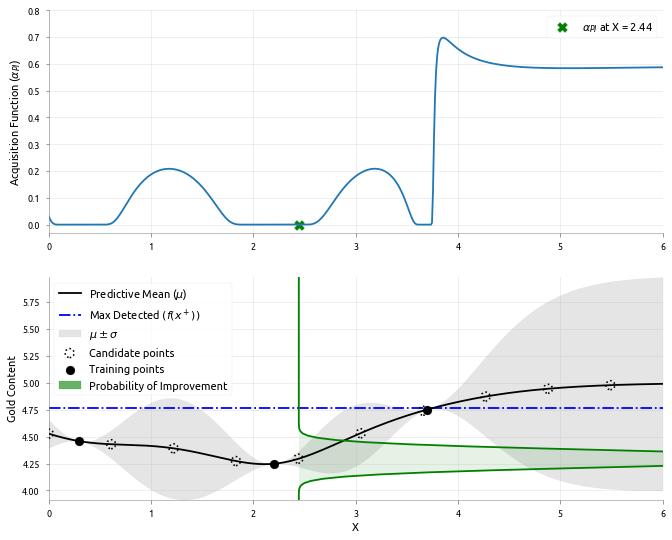

3.045075125208681
0.19216999378659805


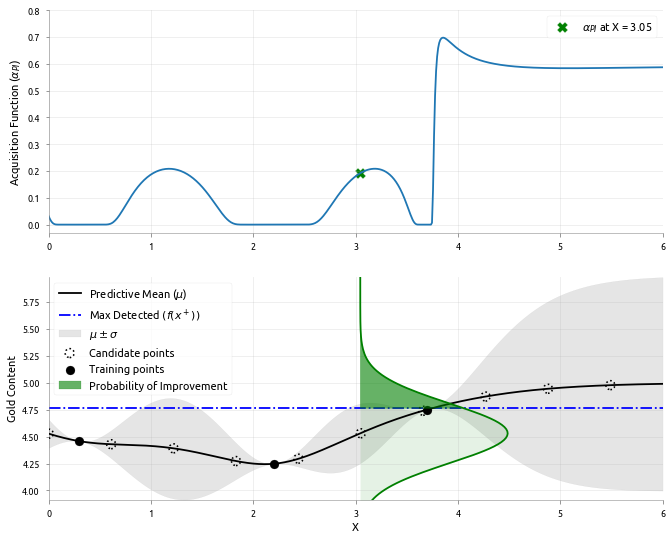

3.656093489148581
6.286998676125833e-29


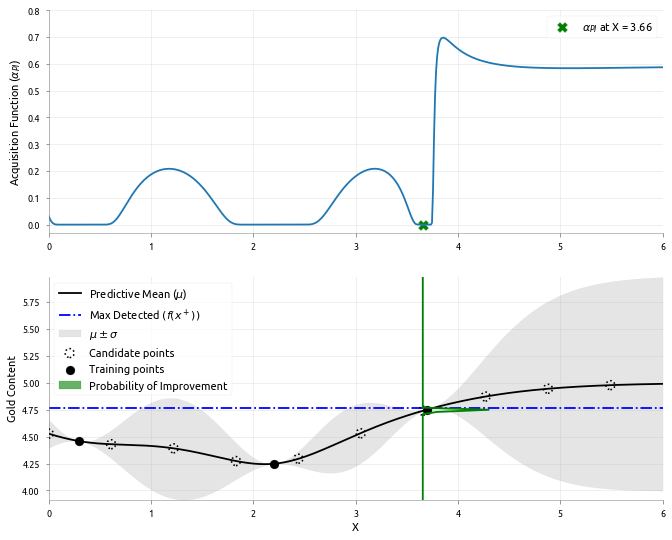

4.267111853088481
0.6078162213912837


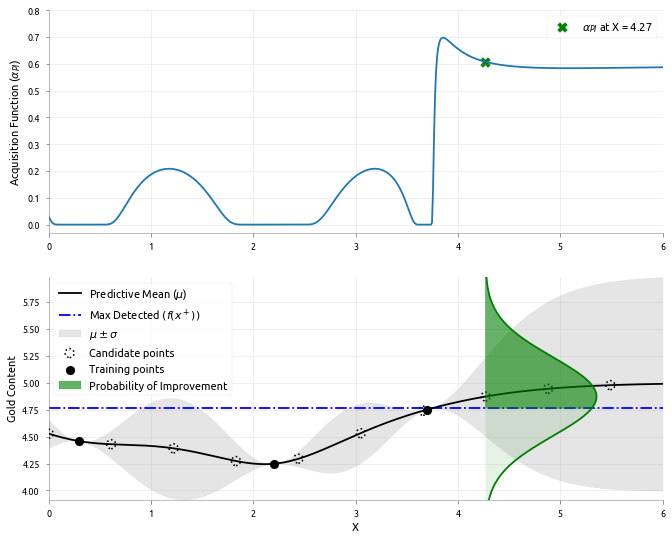

4.878130217028381
0.5843780013693075


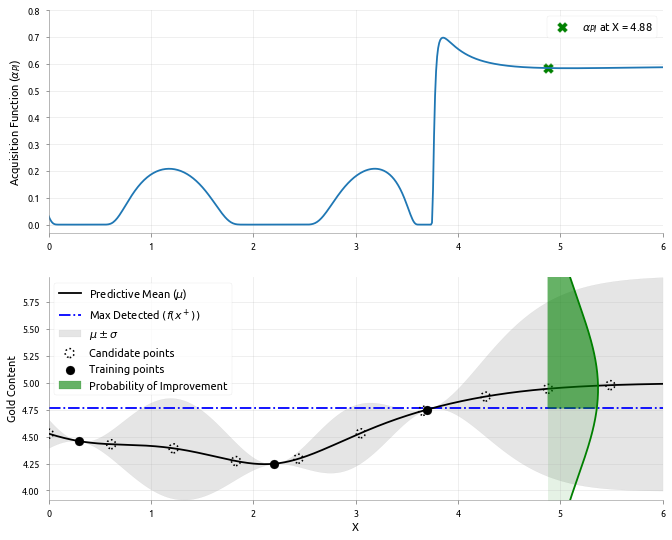

5.489148580968281
0.5849446539109013


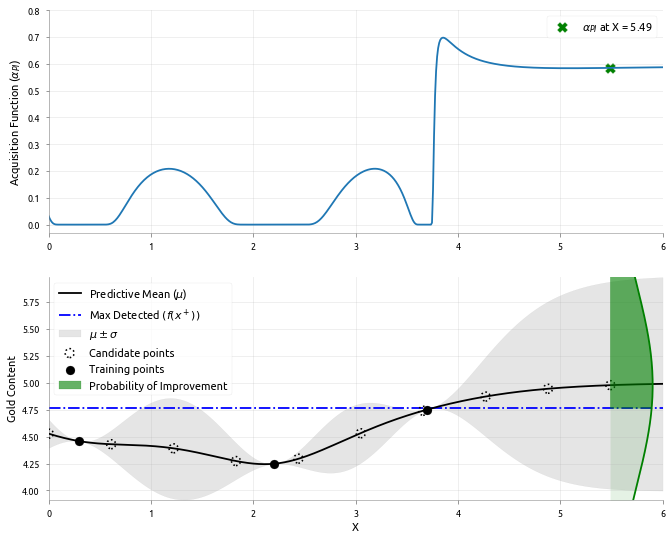

In [219]:
pi_cdf_plot(
    gp, x, train_X, train_y,
    x_locs=np.linspace(0.0, 6.1, 11)[:-1],  val=val,
)

# !convert -delay {delay} -loop 0 MAB_pngs/pi_cdf/*.png {gifDir}/pi_cdf.gif